# A tech UseCase and Data engineering solution## The technical case
We have a shared folder on FTP server where our data provider every week uploads patent data
updates in XML format (Each document is represented as <exch:exchange-document>).
Example package of such files can be found here:
https://drive.google.com/file/d/1u0BNdA2xIRF_FzovAXYGS-wCkrchcy46/view?usp=sharing
Please design a proof-of-concept for a data processing pipeline to parse the input files and
import them into relational database for further analysis and processing.

Elements to extract from the input files:
- country
- doc-number
- kind
- doc-id
- date-publ
- family-id
- classification-ipcr (only text)
- exch:applicant-name (only name)
- exch:invention-title
- exch:abstract


### Author: Sahib Jan 


# Extract, Transform and Load 


In [79]:
from lxml import etree
import pandas as pd
#import xmltodict
from google.cloud import storage
import os
from io import StringIO
import pandas_gbq

os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="/home/jaanhunzai_512/google_key.json"



In [80]:
PROJECT_ID = "mgr-application"
BQ_DATASET = "test_dataset"
BQ_TABLE = "patentDocument"


In [81]:
source_bucket_name = "raw-zone-bucket"
source_object_name = "simple_set.xml"

storage_client = storage.Client()

## 1.  Extract

In [82]:
def extract(path:str)->str:
    """
    - the function extract give XML from source 
    - the source can be cloud storage bucket or FTP 
    - parse the file and creates xml data
    - it returns root element
    """
    storage_client = storage.Client()
    source_bucket_name = "raw-zone-bucket"
    source_object_name = "simple_set.xml"
    source_bucket = storage_client.bucket(source_bucket_name)
   
    source_object = source_bucket.blob(source_object_name)
   
    xml_bytes = source_object.download_as_string()
    root_element= etree.fromstring(xml_bytes)

    return root_element
    

In [83]:
def parse_classification_ipcr(exch_classifications_ipcr:str)-> list:
    """
    - function parses the classification_ipcr tag
    - under "exch:classifications-ipcr" tag there are multiple tags for text
    - for example:
    - <exch:classifications-ipcr>
	- 	<classification-ipcr sequence="1"><text>B01D  15/04        20060101AFI20051220RMJP        </text></classification-ipcr>
	- 	<classification-ipcr sequence="2"><text>B01J  39/18        20170101AFI20200529BHEP        </text></classification-ipcr>
	- 	<classification-ipcr sequence="3"><text>B01D  15/08        20060101ALI20051220RMJP        </text></classification-ipcr>
	- 	<classification-ipcr sequence="4"><text>B01J  20/281       20060101ALI20051220RMJP        </text></classification-ipcr>
	- 	<classification-ipcr sequence="5"><text>B01J  20/32        20060101ALI20200529BHEP        </text></classification-ipcr>
	- 	<classification-ipcr sequence="6"><text>B01J  39/04        20170101ALI20200529BHEP        </text></classification-ipcr>
	- 	<classification-ipcr sequence="7"><text>B01J  39/08        20060101ALI20051220RMJP        </text></classification-ipcr>
	- 	<classification-ipcr sequence="8"><text>B01J  49/00        20060101ALI20051220RMJP        </text></classification-ipcr>
	- 	<classification-ipcr sequence="9"><text>C07K   1/18        20060101ALI20051220RMJP        </text></classification-ipcr>
    - </exch:classifications-ipcr>
    
    - I used list to store all the extracted  text from the tag
    - returns list 
    """
    class_ipcr_text = []
   
    for class_ipcr in exch_classifications_ipcr:
        #print(class_ipcr.tag, class_ipcr.attrib)
        for class_ipcr_sequance in class_ipcr:         
            class_ipcr_text.append(class_ipcr_sequance[0].text)
            

    return class_ipcr_text

In [85]:
def parse_applicants_name(exch_applicant_tag:str)-> list:
    """
    - function parses applicants
    - there are multiple applicants for each document , therefore, i used list to store all applicants
    -<exch:applicants>
			<exch:applicant sequence="1" data-format="docdb">
				<exch:applicant-name><name>CYTIVA BIOPROCESS R&amp;D AB</name></exch:applicant-name>
				<residence><country>SE</country></residence>
			</exch:applicant>
				
			<exch:applicant sequence="1" data-format="docdba">
					<exch:applicant-name><name>Cytiva BioProcess R&amp;D AB</name></exch:applicant-name>
			</exch:applicant>
	- </exch:applicants>
    - returns list
    """
    applicant_name = exch_applicant_tag[0][0][0].text
    return applicant_name

In [86]:
def parse_invention_title(exch_invention_title_tag: str)->str:
    """
    - function returns title written in English
    - <exch:invention-title lang="de" data-format="docdba">ADSORPTIONSVERFAHREN UND LIGANDEN</exch:invention-title>
    - <exch:invention-title lang="en" data-format="docdba">ADSORPTION METHOD AND LIGANDS</exch:invention-title>
    - <exch:invention-title lang="fr" data-format="docdba">PROCEDE D&apos;ADSORPTION ET LIGANDS</exch:invention-title>
    - 
    """
    for title in exch_invention_title_tag:
        if title.attrib['lang']== "en":
            return title.text
    return title.text
            

In [87]:
def parse_abstract(exch_abstract_tag:str)-> str:
    """
    - function extracts abstract
    """
    for abstracts in exch_abstract_tag:
        return abstracts[0].text

In [88]:
def merge_duplicated_records(df: pd.DataFrame) -> pd.DataFrame:
    """
    - the function takes df as an argument and merges the duplicated record
    - groups by "family_id" and merges if records are duplicated
    - return unique records as new data frame
    :param df:
    :return:
    """
    aggreDict = {'doc_identifier': 'first',
                 'country': 'first',
                 'doc_number': 'first',
                 'kind': 'first',
                 'doc_id': 'first',
                 'date_publ': 'first',
                 'family_id': 'first',
                 'classification_ipcr': 'sum',
                 'exch_applicant_name': 'first',
                 "exch_invention_title": "first",
                 "exch_abstract": "first"

                 }
    df_new = df.groupby('family_id', as_index=False).aggregate(aggreDict).reindex(columns=df.columns)
    return df_new

## Transform 
- the function parses the xml documents and creates cleaned dataframe

In [89]:
def transform(root_element: str) -> pd.DataFrame:
    """
    - function parses child tags in the XML document
    - extract values
    - create dataframe, it also create new column by combining three columns kind, country, doc-number columns
    - checks for repeated documents and aggreggates document where family-id are repeated
    - return cleaned dataframe
    :param root_element:
    :return:
    """

    df_cols = ["country", "doc_number", "kind", "doc_id", "date_publ", "family_id", "classification_ipcr",
               "exch_applicant_name", "exch_invention_title", "exch_abstract"]

    namespace = {"exch": 'http://www.epo.org/exchange'}

    records = []

    for i in range(0, 5):  # len(root.getchildren())
        # print(root_element.getchildren()[i])
        child = root_element.getchildren()[i]
        country = child.attrib["country"]
        doc_number = child.attrib["doc-number"]
        kind = child.attrib["kind"]
        doc_id = child.attrib["doc-id"]
        date_publ = child.attrib["date-publ"]
        # print(date_publ)
        family_id = child.attrib["family-id"]

        # extract classifications_ipcr text
        exch_classifications_ipcr_tag = child.findall('.//exch:classifications-ipcr', namespace)
        class_ipcr_text = parse_classification_ipcr(exch_classifications_ipcr_tag)

        # extract applicants name
        exch_applicant_tag = child.findall('.//exch:applicant', namespace)
        applicant_name = parse_applicants_name(exch_applicant_tag)

        # extract invention title
        exch_invention_title_tag = child.findall('.//exch:invention-title', namespace)
        invention_title = parse_invention_title(exch_invention_title_tag)

        # extract document abstract
        exch_abstract_tag = child.findall('.//exch:abstract', namespace)
        abstract = parse_abstract(exch_abstract_tag)

        records.append(
            {
                "country": country,
                "doc_number": doc_number,
                "kind": kind,
                "doc_id": doc_id,
                "date_publ": date_publ,
                "family_id": family_id,
                "classification_ipcr": class_ipcr_text,
                "exch_applicant_name": applicant_name,
                "exch_invention_title": invention_title,
                "exch_abstract": abstract
            }
        )

    df = pd.DataFrame(records, columns=df_cols)

    # create new document identifier by combining colums
    doc_identifier = df["country"] + df["doc_number"] + df["kind"]
    df.insert(0, "doc_identifier", doc_identifier)

    # check for duplicated documents
    if df['family_id'].eq(df['family_id'].iloc[0]).all() == True:
        df_new = merge_duplicated_records(df)  # function aggreggates duplicated documents
    else:
        df_new = df.copy()

    return df_new

## Load into BigQuery

In [90]:
class BigQueryTableError(Exception):
    '''Exception raised whenever a BigQuery table gives error'''

    def __init__(self, errors):
        super().__init__(self._format(errors))
        self.errors = errors

    def _format(self, errors):
        err = []
        for error in errors:
            err.extend(error['errors'])
        return json.dumps(err)


In [91]:
def load_into_BQ(df: pd.DataFrame):
    """
    - The function loads the transformed data frame in the BigQuery table. The function requires pandas_gbq package and the following parameters:
    - PROJECT_ID = os.getenv("GCP_PROJECT")
    - BQ_TABLE = "test_dataset.dataset"
    :param df:
    :return:
    """

    errors = pandas_gbq.to_gbq(df, destination_table=BQ_DATASET + "." + BQ_TABLE,
                               project_id=PROJECT_ID,
                               if_exists="fail"

                               )
    print("errors", errors)
    if errors != None:
        raise BigQueryTableError(errors)

In [92]:
file_path = "simple_set.xml"
xml_elements = extract(file_path)
xml_elements

<Element {http://www.epo.org/exchange}exchange-documents at 0x7f98b7521d80>

In [93]:
df_cleaned = transform(xml_elements)
df_cleaned

,doc_identifier,country,doc_number,kind,doc_id,date_publ,family_id,classification_ipcr,exch_applicant_name,exch_invention_title,exch_abstract
0,EP1301279B1,EP,1301279,B1,538386249,20201028,20280522,[B01D 15/04 20060101AFI20051220RMJP ...,CYTIVA BIOPROCESS R&D AB,ADSORPTION METHOD AND LIGANDS,The invention relates to a method for removing...
1,EP1409016B9,EP,1409016,B9,538386252,20201028,23162250,[A61K 39/395 20060101AFI20190830BHEP ...,AMGEN FREMONT INC,ANTIBODIES TO OPGL,Antibodies that interact with osteoprotegerin ...
2,EP1658542B1,EP,1658542,B1,538386246,20201028,34216734,[G05D 16/20 20060101AFI20050311BHEP ...,HONEYWELL INT INC,TWO STAGE SOLENOID CONTROL VALVE,A two stage solenoid control valve is describe...
3,EP1682985B1,EP,1682985,B1,538386304,20201028,34573755,[H04L 29/06 20060101AFI20130301BHEP ...,EXTREME NETWORKS INC,DISTRIBUTED INTRUSION RESPONSE SYSTEM,A system and method to respond to intrusions d...
4,EP3729173A1,EP,3729173,A1,538387584,20201028,66815169,[G02B 27/01 20060101AFI20190628BHEP ...,FACEBOOK TECH LLC,INTEGRATED AUGMENTED REALITY HEAD-MOUNTED DISP...,A method for providing augmented reality conte...


In [78]:
alist = df_cleaned.classification_ipcr.head(1).tolist()
for i in range (0, len(alist)):
    print(i, alist[i])

0 ['B01D  15/04        20060101AFI20051220RMJP        ', 'B01J  39/18        20170101AFI20200529BHEP        ', 'B01D  15/08        20060101ALI20051220RMJP        ', 'B01J  20/281       20060101ALI20051220RMJP        ', 'B01J  20/32        20060101ALI20200529BHEP        ', 'B01J  39/04        20170101ALI20200529BHEP        ', 'B01J  39/08        20060101ALI20051220RMJP        ', 'B01J  49/00        20060101ALI20051220RMJP        ', 'C07K   1/18        20060101ALI20051220RMJP        ']


In [44]:
#load_into_BQ(df_cleaned)

errors None


In [25]:
"""
def cloud_function_entry_point(request):
    """
    - cloud_function_entry_point is an entry-point in the cloud function
    - deploy the code as a cloud function
    :param file_path:
    :return:
    """

    file_path = "simple_set.xml"

    try:
        xml_elements = extract(file_path)
        #print(xml_elements)
    except:
        print("problem in extracting data from given data source")

    try:
        df_cleaned = transform(xml_elements)
        print(df_cleaned)
    except:
        print("problem in parsing xml ")

    try:
        load_into_BQ(df_cleaned)

    except:
        print("problem in loading data to BigQuery Table")

    return "Process Completed!"
"""

,doc_identifier,country,doc_number,kind,doc_id,date_publ,family_id,classification_ipcr,exch_applicant_name,exch_invention_title,exch_abstract
0,EP1301279B1,EP,1301279,B1,538386249,20201028,20280522,[B01D 15/04 20060101AFI20051220RMJP ...,CYTIVA BIOPROCESS R&D AB,ADSORPTION METHOD AND LIGANDS,The invention relates to a method for removing...
1,EP1409016B9,EP,1409016,B9,538386252,20201028,23162250,[A61K 39/395 20060101AFI20190830BHEP ...,AMGEN FREMONT INC,ANTIBODIES TO OPGL,Antibodies that interact with osteoprotegerin ...
2,EP1658542B1,EP,1658542,B1,538386246,20201028,34216734,[G05D 16/20 20060101AFI20050311BHEP ...,HONEYWELL INT INC,TWO STAGE SOLENOID CONTROL VALVE,A two stage solenoid control valve is describe...
3,EP1682985B1,EP,1682985,B1,538386304,20201028,34573755,[H04L 29/06 20060101AFI20130301BHEP ...,EXTREME NETWORKS INC,DISTRIBUTED INTRUSION RESPONSE SYSTEM,A system and method to respond to intrusions d...
4,EP3729173A1,EP,3729173,A1,538387584,20201028,66815169,[G02B 27/01 20060101AFI20190628BHEP ...,FACEBOOK TECH LLC,INTEGRATED AUGMENTED REALITY HEAD-MOUNTED DISP...,A method for providing augmented reality conte...


In [22]:
df_cleaned.dtypes

doc_identifier          object
country                 object
doc_number              object
kind                    object
doc_id                  object
date_publ               object
family_id               object
classification_ipcr     object
exch_applicant_name     object
exch_invention_title    object
exch_abstract           object
dtype: object

- There are morethen 5000 patent documents in the give XML
- All the documents are sucessfully parsed using the ETL script
- for loading in BigQuery i use simple_set from the given XML with few patent documents


## 1. Deployment on GCP as a Cloud Function

We can use the above code together with function cloud_function_entry_point as cloud function to automate the extract, transform and load process as cloud function

    step 1. Create cloud function
    step 2. populate the requirments.txt with required packages
    step 3. enable http trigger type
    step 4. allow Authentication
    step 5. increase memory allocated to 2GB
    step 6. integrate code by uploading zip folder or paste all code inline Editor
        step 6.1. set entry point cloud_function_entry_point
    step 7. add packages in requirement.txt
    step 8. deploy the function
    step 9. test the function
    step 10. check the table schema and data in biqQuery table

The cloud function can be scheduled using Cloud Scheduler to trigger the cloud function on defined scheduled

    scheduling requires unix-cron format.



## GCP Cloud function workflow
- The workflow gives overview of the proposed deployment approach. The deployment as cloud function has been tested to parse xml document and load data as records into BigQuery Table:

    BQ_DATASET = "test_dataset"
    BQ_TABLE = "patentDocument"

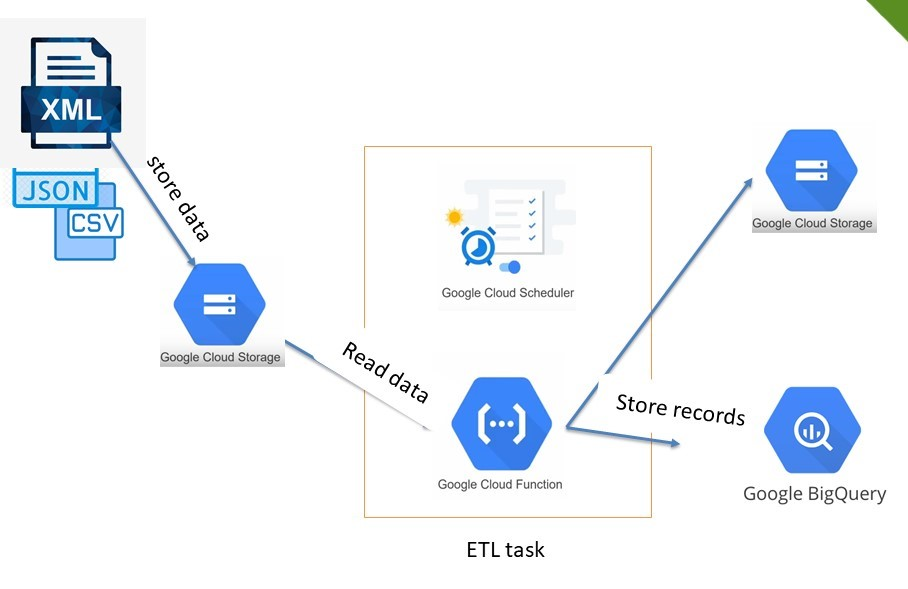

## Created BigQuery Dataset
- for final Bigquery testing,i used simple data set of 10 patent documents. 


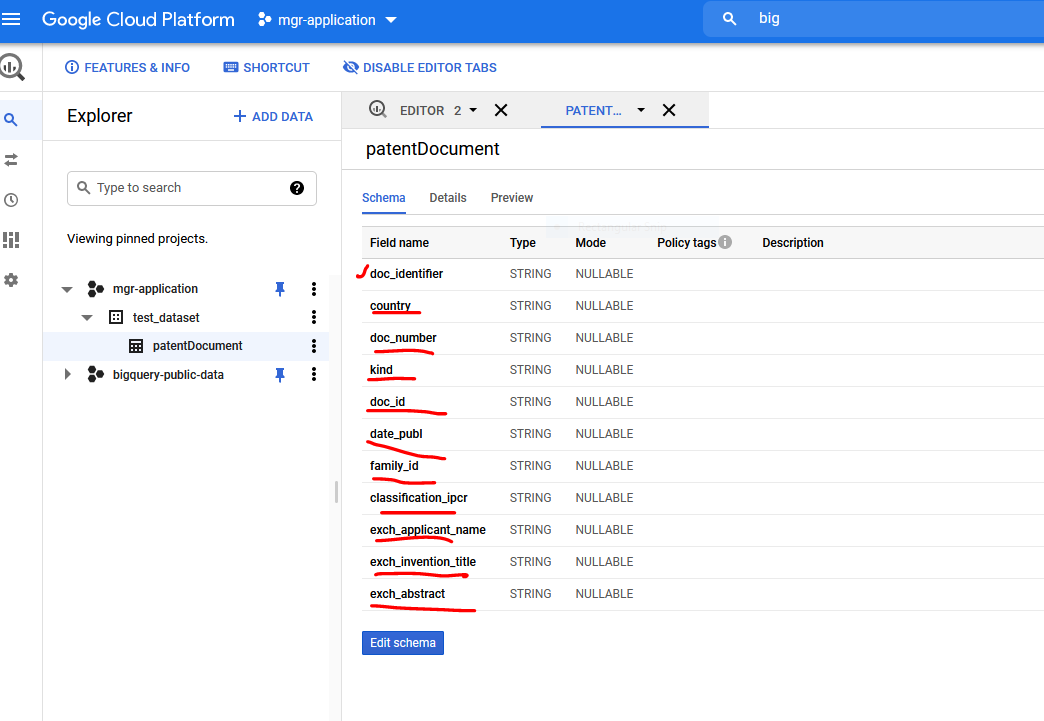




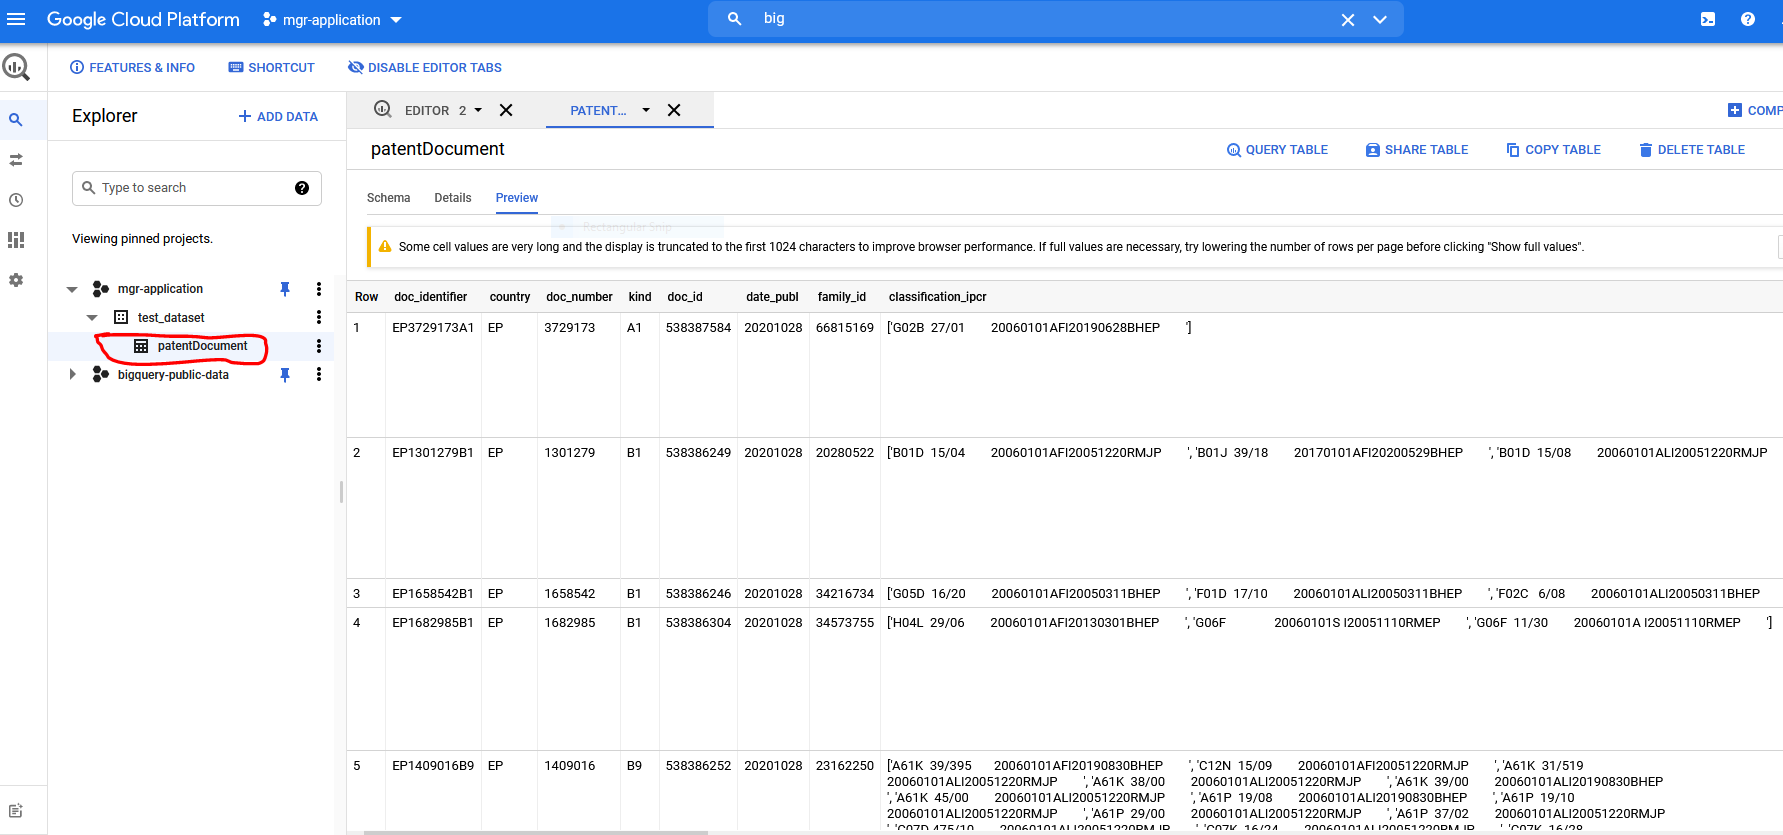




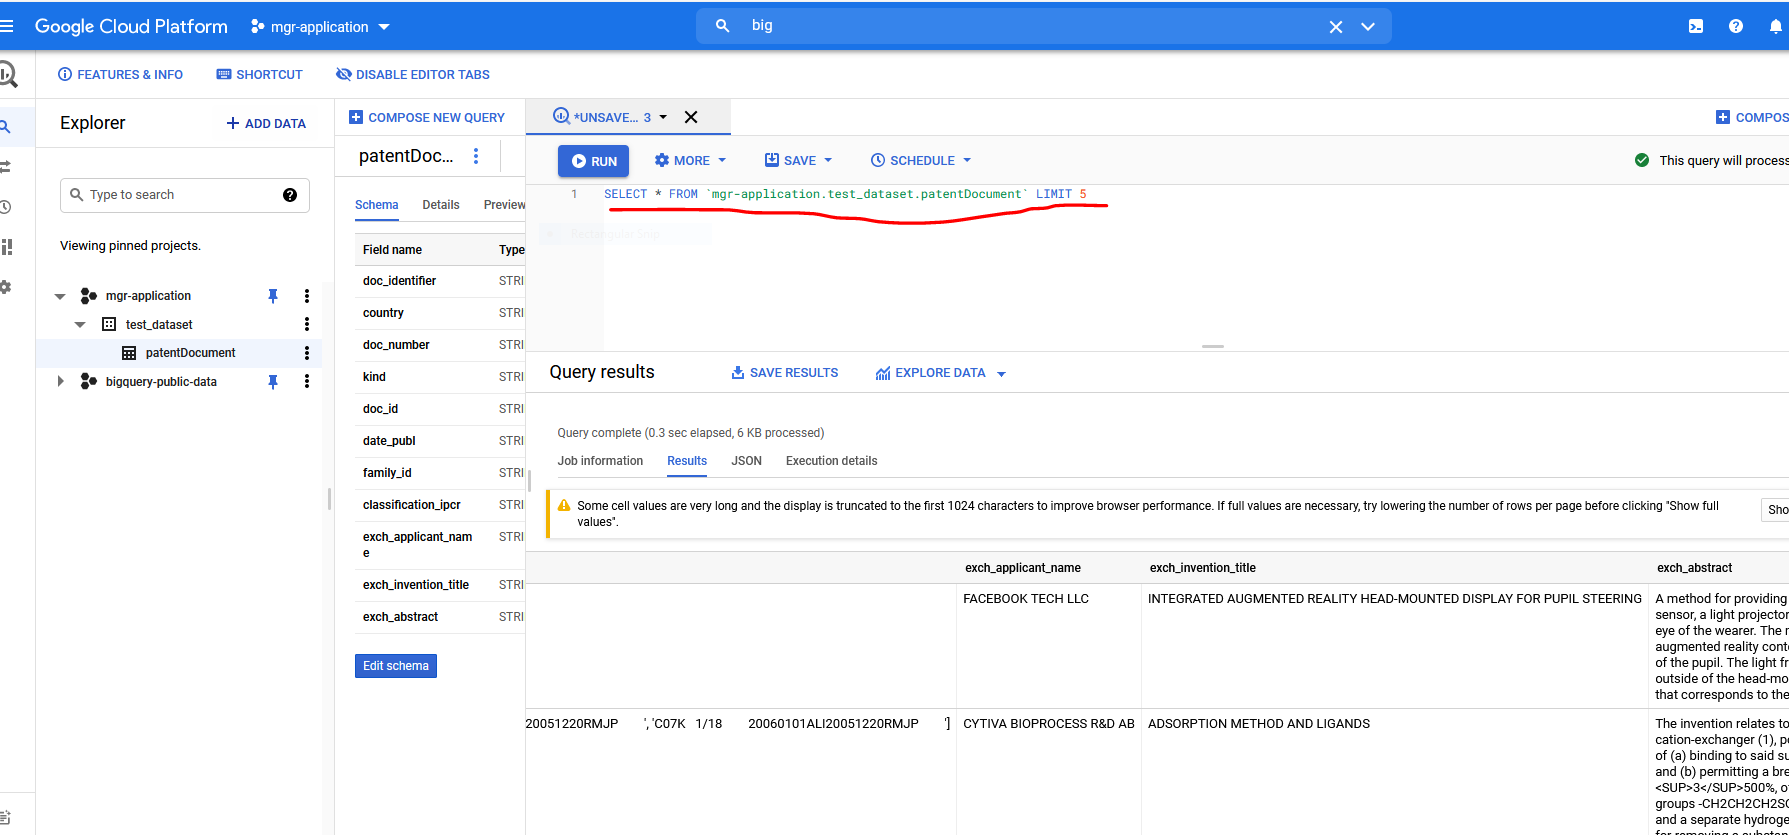

### Alternate  Deployment using Airflow DAG

As an alternate approach, we can create Dag and deploy the DAG in Google Cloud composer. The DAG can be triggered using cloud function or defined schedule
Deployment workflow will be as follows:

    - extract data from API
    - store data as a raw data in **raw_zone_storage_bucket**
    - extract data from **raw_zone_storage_bucket** and transform the data
    - store the process data into a **clean_zone_storage_bucket** as parquet file format
    - create **bigQueryExternalTable** for the stored parquet file format
    - the bigqueryExternalTable keep only reference to the parquet file not the actual data
    - Only query will charge in this case

AirFlow DAG Tasks

    - extract data from API using  **airflow.operators.http_operator**
    - transform data by using python code with  **airflow.operators.python_operator**
    - load data in to BigQuery using **airflow.providers.google.cloud.operators.bigquery**